## RL State Space Engineering: Q-Learning with LSTM-Based Health States

To enable uncertainty aware reinforcement learning for Remaining Useful Life (RUL) based maintenance decision making, we construct a **model driven discrete state space** for **tabular Q-learning**. Instead of exposing raw sensor measurements to the agent, the state representation is derived from the predictions of a Bayesian LSTM model. This approach ensures that the reinforcement learning agent operates on a compact, physically meaningful state signal while remaining compatible with classical Q-learning.

### 1. Model-Based State Construction

The pre trained **Bayesian LSTM with Monte Carlo Dropout** is used to estimate the Remaining Useful Life for each engine cycle.  
For every time step, the model outputs:
- **Predicted mean RUL**
- **Predicted standard deviation**, representing predictive uncertainty

These quantities replace raw sensor data as the information source available to the Q learning agent.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('seaborn-v0_8-whitegrid')

# ECONOMIC CONFIGURATION
COST_MAINTENANCE = 100
COST_FAILURE = 1000
REWARD_UPTIME = 40

# Paths
data_path = '../data/processed/train_featured.csv'
model_path = '../models/lstm_uncertainty_v1.keras'


### 2. Uncertainty Aware RUL Representation

- To incorporate prediction reliability into the decision process, a **conservative RUL estimate** is defined by penalizing uncertainty.  
- Higher uncertainty effectively reduces the usable RUL estimate, encouraging the agent to behave more cautiously when predictions are unreliable.
- This mechanism allows uncertainty to influence decisions implicitly, without increasing the dimensionality of the state space.

In [2]:
# Load data and model
train_df = pd.read_csv(data_path)
lstm_model = tf.keras.models.load_model(model_path)

drop_cols = [
    'unit_number', 'time_cycles', 'RUL', 'max_life',
    'RUL_clipped', 'RUL_scaled', 'state',
    'setting_1', 'setting_2', 'setting_3'
]

feature_cols = [c for c in train_df.columns if c not in drop_cols]


In [3]:
def generate_lstm_states(df, model, seq_len=30):
    df = df.copy()
    df['pred_mean'] = np.nan
    df['pred_std'] = np.nan

    for unit in df['unit_number'].unique():
        idx = df[df['unit_number'] == unit].index
        if len(idx) < seq_len:
            continue
        
        data = df.loc[idx, feature_cols].values
        X_seq = []
        valid_idx = idx[seq_len-1:]

        for i in range(seq_len, len(data) + 1):
            X_seq.append(data[i-seq_len:i])

        X_seq = np.array(X_seq)
        preds = [model(X_seq, training=True) for _ in range(5)]
        preds = np.array(preds).squeeze()

        df.loc[valid_idx, 'pred_mean'] = preds.mean(axis=0) * 125.0
        df.loc[valid_idx, 'pred_std']  = preds.std(axis=0) * 125.0
    return df.dropna(subset=['pred_mean']).reset_index(drop=True)

rl_data = generate_lstm_states(train_df, lstm_model)


### 3. Discrete State Definition for Q-Learning

The conservative RUL estimate is discretized into **fixed 10 cycle intervals**, forming a finite state space suitable for tabular Q-learning. Each discrete state corresponds to a specific RUL range:

- State 0: 0–10 cycles  
- State 1: 10–20 cycles  
- State 2: 20–30 cycles  
- …

Lower states indicate upcoming failure, while higher states represent healthier operating conditions. The state index is capped to prevent unnecessary growth of the Q-table.


In [4]:
def define_state(row):
    conservative_rul = row['pred_mean'] - 0.5 * row['pred_std']
    state = int(max(0, conservative_rul) / 10)
    return min(state, 15)

rl_data['state'] = rl_data.apply(define_state, axis=1)
print("State distribution:")
print(rl_data['state'].value_counts().sort_index())


State distribution:
state
1      795
2     2398
3      576
4      429
5      468
6      723
7     1795
8     1421
9     1222
10    1630
11    2325
12     456
13       3
Name: count, dtype: int64


### 4. Q-Learning Formulation

The maintenance decision problem is modeled as a **renewal process**:

- **Continue** → earns uptime reward
- **Repair** → incurs maintenance cost and resets engine health
- **Failure** → incurs large penalty and resets the engine

The agent learns a state dependent policy that maximizes long term economic reward.


In [5]:
# Hyperparameters
episodes = 30000
horizon = 200   
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.9998
alpha = 0.1
gamma = 0.6     

NUM_STATES = 16
q_table = np.zeros((NUM_STATES, 2))
rewards_history = []
units = rl_data['unit_number'].unique()

for episode in range(episodes):
    unit_id = random.choice(units)
    unit_data = rl_data[rl_data['unit_number'] == unit_id].reset_index(drop=True)
    step = 0
    total_reward = 0
    
    for _ in range(horizon):
        state = int(unit_data.loc[step, 'state'])
        true_rul = unit_data.loc[step, 'RUL'] 
        
        # Epsilon-Greedy Action
        if random.random() < epsilon:
            action = random.choice([0, 1])
        else:
            action = np.argmax(q_table[state])
            
        # Dynamics
        reward = 0
        reset_unit = False
        
        if action == 1: # REPAIR
            reward = -COST_MAINTENANCE
            reset_unit = True 
        else: # CONTINUE
            if true_rul <= 0: # FAILURE
                reward = -COST_FAILURE
                reset_unit = True
            else: # UPTIME
                reward = REWARD_UPTIME
                step += 1
                if step >= len(unit_data): reset_unit = True
        
        # Next State
        if reset_unit:
            unit_id = random.choice(units)
            unit_data = rl_data[rl_data['unit_number'] == unit_id].reset_index(drop=True)
            step = 0
            next_state = int(unit_data.loc[step, 'state'])
        else:
            next_state = int(unit_data.loc[step, 'state'])
            
        # Update Q-Table
        old_val = q_table[state, action]
        next_max = np.max(q_table[next_state])
        q_table[state, action] = old_val + alpha * (reward + gamma * next_max - old_val)
        
        total_reward += reward
        
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_history.append(total_reward)

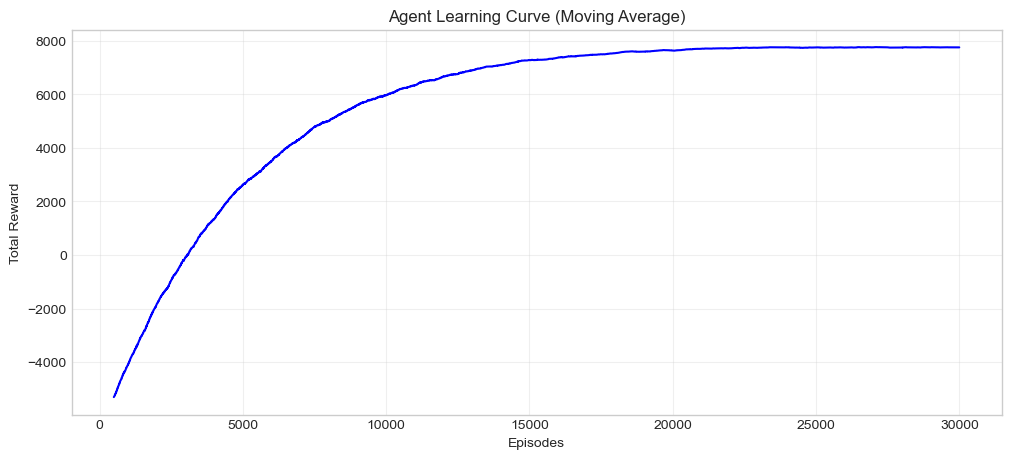


State (RUL Bin)      | Decision  
-----------------------------------
RUL 0-10       | Continue
RUL 10-20       | Repair
RUL 20-30       | Continue
RUL 30-40       | Continue
RUL 40-50       | Continue
RUL 50-60       | Continue
RUL 60-70       | Continue
RUL 70-80       | Continue
RUL 80-90       | Continue
RUL 90-100      | Continue
RUL 100-110      | Continue
RUL 110-120      | Continue
RUL 120-130      | Continue
RUL 130-140      | Continue
RUL 140-150      | Continue
RUL 150-160      | Continue


In [6]:
plt.figure(figsize=(12, 5))
moving_avg = pd.Series(rewards_history).rolling(window=500).mean()
plt.plot(moving_avg, color='blue', linewidth=1.5)
plt.title('Agent Learning Curve (Moving Average)')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)
plt.show()

# Learned Policy
print(f"\n{'State (RUL Bin)':<20} | {'Decision':<10}")
print("-" * 35)
for i in range(NUM_STATES):
    best = ['Continue', 'Repair'][np.argmax(q_table[i])]
    print(f"RUL {i*10}-{(i+1)*10:<8} | {best}")

### 5. Economic Evaluation

The learned Q-learning policy is evaluated against a fixed-threshold baseline policy.  Performance is measured by **total accumulated profit** over a long horizon fleet simulation.


Simulating 100,000 operational hours...
Final Net Economic Gain: $112,020


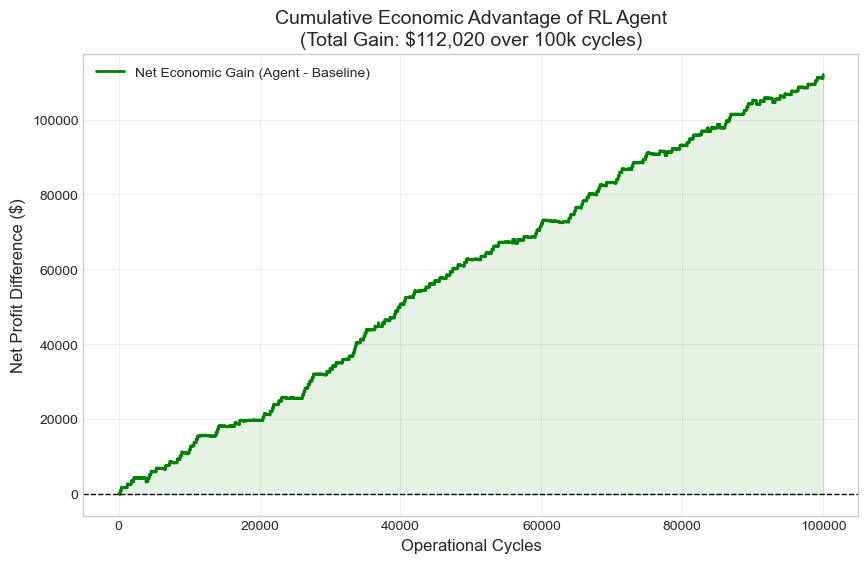

In [8]:
def simulate_economy_history(df, policy_type='agent', threshold=20, total_steps=100000):
    rng = np.random.default_rng(42)
    units = df['unit_number'].unique()

    history = []
    current_unit = rng.choice(units)
    unit_data = df[df['unit_number'] == current_unit].reset_index(drop=True)
    step = 0
    
    running_profit = 0
    
    for _ in range(total_steps):
        state = int(unit_data.loc[step, 'state'])
        true_rul = unit_data.loc[step, 'RUL']
        pred_rul = unit_data.loc[step, 'pred_mean']
        
        # Decision
        action = 0
        if policy_type == 'agent':
            action = np.argmax(q_table[state])
        elif policy_type == 'baseline':
            if pred_rul <= threshold: action = 1
            
        # Dynamics
        step_reward = 0
        if action == 1: # Repair
            step_reward = -COST_MAINTENANCE
            current_unit = rng.choice(units)
            unit_data = df[df['unit_number'] == current_unit].reset_index(drop=True)
            step = 0
        else: # Continue
            if true_rul <= 0: # Fail
                step_reward = -COST_FAILURE
                current_unit = rng.choice(units)
                unit_data = df[df['unit_number'] == current_unit].reset_index(drop=True)
                step = 0
            else: # Uptime
                step_reward = REWARD_UPTIME
                step += 1
                if step >= len(unit_data):
                    current_unit = rng.choice(units)
                    unit_data = df[df['unit_number'] == current_unit].reset_index(drop=True)
                    step = 0
        
        running_profit += step_reward
        history.append(running_profit)
                    
    return np.array(history)

print("Simulating 100,000 operational hours...")
agent_hist = simulate_economy_history(rl_data, policy_type='agent')
baseline_hist = simulate_economy_history(rl_data, policy_type='baseline', threshold=20)
net_advantage = agent_hist - baseline_hist
final_gain = net_advantage[-1]

print(f"Final Net Economic Gain: ${final_gain:,.0f}")

plt.figure(figsize=(10, 6))
plt.plot(net_advantage, color='green', linewidth=2, label='Net Economic Gain (Agent - Baseline)')
plt.fill_between(range(len(net_advantage)), net_advantage, 0, color='green', alpha=0.1)
plt.title(f'Cumulative Economic Advantage of RL Agent\n(Total Gain: ${final_gain:,.0f} over 100k cycles)', fontsize=14)
plt.xlabel('Operational Cycles', fontsize=12)
plt.ylabel('Net Profit Difference ($)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6. Decision Boundary Visualization
We visualize the agent's behavior on a sample unit to confirm it acts preventively before failure.

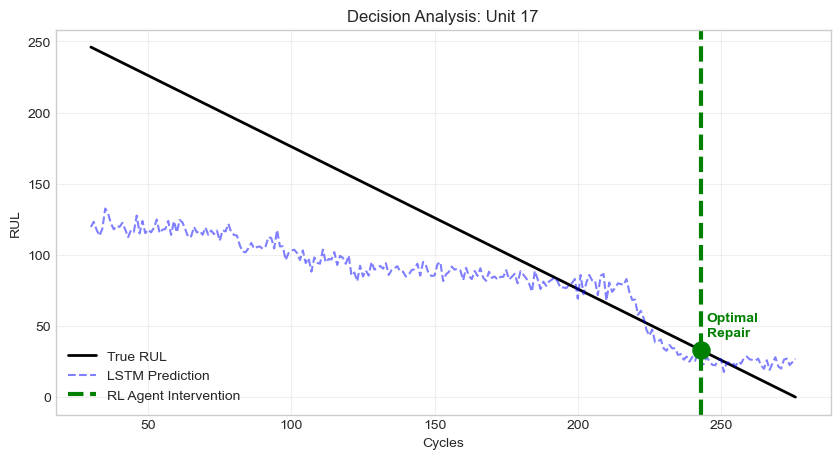

In [9]:
def plot_decision(unit_id):
    unit_data = rl_data[rl_data['unit_number'] == unit_id].reset_index(drop=True)
    stop_step = None
    
    # Find intervention point
    for i in range(len(unit_data)):
        state = unit_data.loc[i, 'state']
        if np.argmax(q_table[state]) == 1:
            stop_step = i
            break
            
    plt.figure(figsize=(10, 5))
    plt.plot(unit_data['time_cycles'], unit_data['RUL'], 'k', label='True RUL', linewidth=2)
    plt.plot(unit_data['time_cycles'], unit_data['pred_mean'], 'b--', label='LSTM Prediction', alpha=0.5)
    if stop_step:
        cycle = unit_data.loc[stop_step, 'time_cycles']
        rul = unit_data.loc[stop_step, 'RUL']
        plt.axvline(x=cycle, color='g', linestyle='--', linewidth=3, label='RL Agent Intervention')
        plt.scatter(cycle, rul, s=150, color='g', zorder=5)
        plt.text(cycle+2, rul+10, 'Optimal\nRepair', color='green', fontweight='bold')
        
    plt.title(f'Decision Analysis: Unit {unit_id}')
    plt.xlabel('Cycles')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_decision(17)